In [35]:
% matplotlib inline
import requests, warnings, json, time, os, re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### IOOS Southern Ocean Data requests

Ask Sheri about the Water pCO2 <br>
DO - looks bad (Be weary)!

__Creating a credentials file__ <br>
This is done so you aren't uploading your private token and username onto a github repo for the whole world to see

1. Create a file called credentials.json in this folder.
2. Add your token and username info so it looks something like this:

```
{
    "username": "OOIAPI-FAKEAPINAME",
    "token": "BBN3YLYO783"
}

```

In [3]:
# Load your credentials
with open("credentials.json", "r") as read_file:
    data = json.load(read_file)
token = data['token']
username = data['username']

### Pull Surface Dissolved Oxygen Data from the [Apex Surface Mooring](http://ooi.visualocean.net/instruments/view/GS01SUMO-RID16-03-CTDBPF000)

Example M2M url:
https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GS01SUMO/RID16/03-CTDBPF000/metadata

In [4]:
# Build API Query

DATA_API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
data_request_url = DATA_API_BASE_URL+\
                    'GS01SUMO/'+\
                    'SBD11/'+\
                    '04-DOSTAD000/'+\
                    'telemetered/'+\
                    'dosta_abcdjm_dcl_instrument'+'?'

r = requests.get(data_request_url, params=None, auth=(username, token)) # Request data
data = r.json() # verify request

In [5]:
# if data says something about a 404 message, double check the API url. Otherwwi
print(data)

{'requestUUID': 'c71185e1-0716-4fec-be9a-1e85bc67b9ee', 'numberOfSubJobs': 97, 'sizeCalculation': 735492264, 'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/pdaniel@mbari.org/20180822T221141-GS01SUMO-SBD11-04-DOSTAD000-telemetered-dosta_abcdjm_dcl_instrument/catalog.html', 'https://opendap.oceanobservatories.org/async_results/pdaniel@mbari.org/20180822T221141-GS01SUMO-SBD11-04-DOSTAD000-telemetered-dosta_abcdjm_dcl_instrument'], 'timeCalculation': 154, 'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/pdaniel@mbari.org/20180822T221141-GS01SUMO-SBD11-04-DOSTAD000-telemetered-dosta_abcdjm_dcl_instrument/catalog.html'}


__Waiting for the dataset to be built and sent to your THREDDS__

In [6]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 2.88 s, sys: 190 ms, total: 3.07 s
Wall time: 3min 2s


### Pull the data from Thredds ###

This chunk of code scrapes the thredds server associated with your username and finds each of the netCDF files that are associated with each deployment (three files in this case) and puts there URLs into a list

In [7]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T221141-GS01SUMO-SBD11-04-DOSTAD000-telemetered-dosta_abcdjm_dcl_instrument/deployment0003_GS01SUMO-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20161125T011201.966000-20180822T180218.225000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T221141-GS01SUMO-SBD11-04-DOSTAD000-telemetered-dosta_abcdjm_dcl_instrument/deployment0003_GS01SUMO-SBD11-04-DOSTAD000-telemetered-dosta_abcdjm_dcl_instrument_20161125T011511.156000-20180822T180303.103000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T221141-GS01SUMO-SBD11-04-DOSTAD000-telemetered-dosta_abcdjm_dcl_instrument/deployment0002_GS01SUMO-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20151214T202021.824000-20161128T070124.679000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/pdaniel@mbari.org/20180822T221141-GS01SUMO-SBD11-04-DOSTAD000-tele

Remove the met data that is also pulled with a request for dissolved oxygen.

This is done by looping through the file names and searching for each string for "METBKA000". If the find method can't find "METBKA000", then it will return -1

In [25]:
datasets = [d for d in datasets if d.find('METBKA000') == -1]


Xarray is amazing and can open multiple netCDF files if they have the same Coordinates, (which each instrument deployment should have!). 

These data a thrown into a xarray Dataset (this is sort of the fundamental unit of xarray and is basically a 3-D array (or more) that keeps some track of some of the metadata)

In [26]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.

Lets print the data varaibles and the corresponding standard names

In [27]:
for var in ds.variables:
    try:
        print(ds[var].standard_name + ':', var)
    except: #hack to only print variables that have a standard name attribute
        pass

time: time
moles_of_oxygen_per_unit_mass_in_sea_water: dissolved_oxygen
latitude: lat
longitude: lon


In [28]:
ds

<xarray.Dataset>
Dimensions:                                     (time: 9052780)
Coordinates:
    obs                                         (time) int64 0 1 2 3 4 5 6 7 ...
  * time                                        (time) datetime64[ns] 2015-02-18T21:15:12.760999424 ...
    lat                                         (time) float64 dask.array<shape=(9052780,), chunksize=(9052780,)>
    lon                                         (time) float64 dask.array<shape=(9052780,), chunksize=(9052780,)>
Data variables:
    deployment                                  (time) int32 dask.array<shape=(9052780,), chunksize=(9052780,)>
    id                                          (time) |S64 dask.array<shape=(9052780,), chunksize=(9052780,)>
    blue_amplitude                              (time) float64 dask.array<shape=(9052780,), chunksize=(9052780,)>
    blue_phase                                  (time) float64 dask.array<shape=(9052780,), chunksize=(9052780,)>
    calibrated_phase      

Plot the Temperature timeseries and the QC flags

(736330.0, 736934.0)

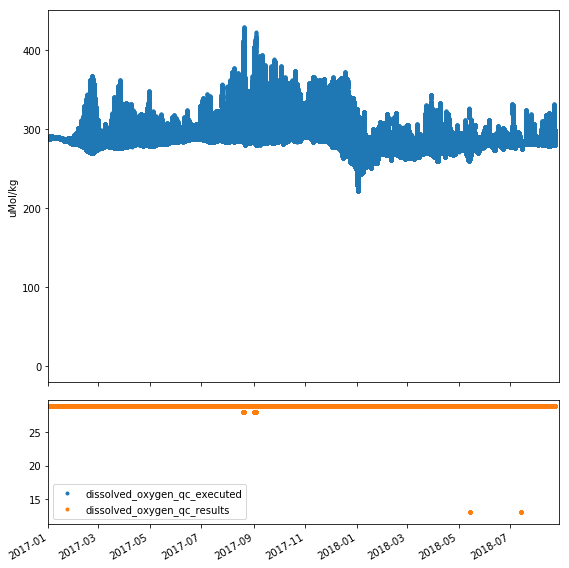

In [32]:
fig, (ax, ax_qc) = plt.subplots(2,sharex=True,gridspec_kw={'height_ratios':[3, 1]})
fig.set_size_inches(8,8)
ax.plot(ds['time'], ds['dissolved_oxygen'], marker='.', linewidth=0)
ax.set_ylabel('uMol/kg')
ax_qc.plot(ds['time'], ds['dissolved_oxygen_qc_executed'],marker='.', linewidth=0)
ax_qc.plot(ds['time'], ds['dissolved_oxygen_qc_results'],marker='.', linewidth=0)
ax_qc.legend()

fig.autofmt_xdate()
fig.tight_layout()

ax.set_xlim(dt.datetime(2017,1,1),dt.datetime(2018,8,28))

In [37]:
dateTime = ds['time'].values
np.nanmean(np.diff(dateTime) / np.timedelta64(1, 's'))

12.224629623897805

In [44]:
subsset_datetime = ds['time'].sel(time=slice('2017-01-01','2018-08-01'))

In [47]:
dateTime = subsset_datetime['time'].values
np.nanmean(np.diff(dateTime) / np.timedelta64(1, 's'))

10.582084210256406

In [49]:
ds['dissolved_oxygen'].resample('1H',how=np.mean)

ValueError: Resampling only supported along single dimensions.